# Algorithme de sélection des bandes discriminatives (one-vs-all) et Classification binaires MLP 

**Dans ce notebook, nous implémentons un algorithme de sélection de bandes discriminatives basé sur une approche "one-vs-all" qui calcule le chevauchement normalisé entre chaque classe et toutes les autres classes pour identifier les bandes les plus séparables. Nous analysons les résultats pour déterminer les bandes les plus discriminantes par classe et globalement, puis nous entraînons des modèles de réseaux de neurones MLP avec deux stratégies de sélection de bandes : la méthode "Top 10" qui sélectionne les 10 meilleures bandes par classe, et la méthode "par ranges" qui divise le spectre en 8 segments et sélectionne la meilleure bande de chaque segment. Nous évaluons et comparons les performances de classification binaire (une classe vs toutes les autres) pour chaque approche en utilisant des métriques comme F1-score, AUC et accuracy, avec validation par méthodes aléatoires et "top-down" (pires bandes) pour démontrer l'efficacité de notre approche de sélection.**

Dimensions de l'image: (145, 145, 200)
Nombre de pixels: 21025
Nombre de bandes spectrales: 200
Nombre de classes: 17
Classes disponibles (sans le fond): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Traitement de la classe 1 (Alfalfa)...
Traitement de la classe 2 (Corn-notill)...


<ipython-input-2-4a4c6f8bc8ac>:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultats_onevsall = pd.concat([resultats_onevsall, pd.DataFrame([nouvelle_ligne])], ignore_index=True)


Traitement de la classe 3 (Corn-mintill)...
Traitement de la classe 4 (Corn)...
Traitement de la classe 5 (Grass-pasture)...
Traitement de la classe 6 (Grass-trees)...
Traitement de la classe 7 (Grass-pasture-mowed)...
Traitement de la classe 8 (Hay-windrowed)...
Traitement de la classe 9 (Oats)...
Traitement de la classe 10 (Soybean-notill)...
Traitement de la classe 11 (Soybean-mintill)...
Traitement de la classe 12 (Soybean-clean)...
Traitement de la classe 13 (Wheat)...
Traitement de la classe 14 (Woods)...
Traitement de la classe 15 (Buildings-Grass-Trees-Drives)...
Traitement de la classe 16 (Stone-Steel-Towers)...

Les 5 bandes les plus discriminantes pour chaque classe (approche one-vs-all):

Classe 1 (Alfalfa):
 Bande  Chevauchement
    38       0.064101
    40       0.068303
   128       0.070883
    44       0.076025
    41       0.076520

Classe 2 (Corn-notill):
 Bande  Chevauchement
     4       0.347895
    96       0.370797
    95       0.377523
     5       0.387683
   

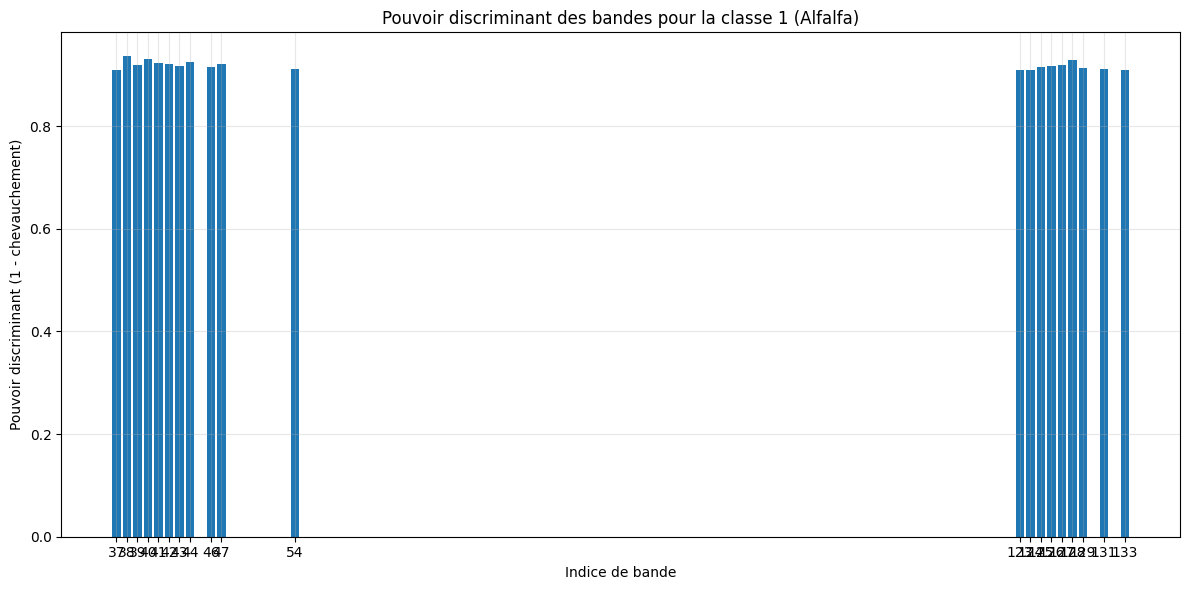

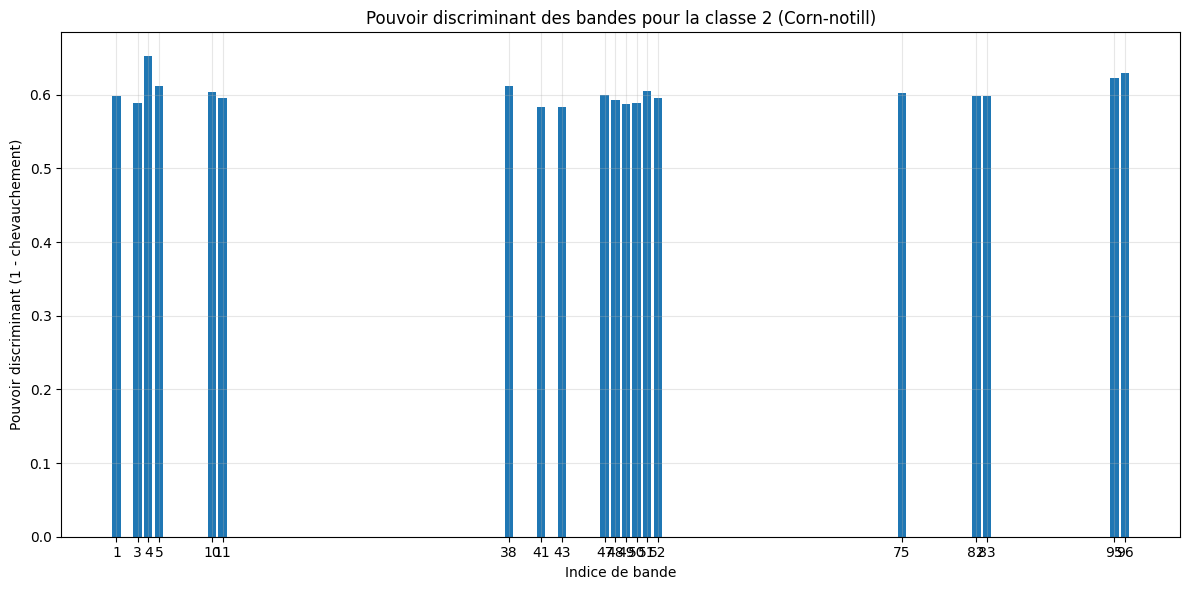

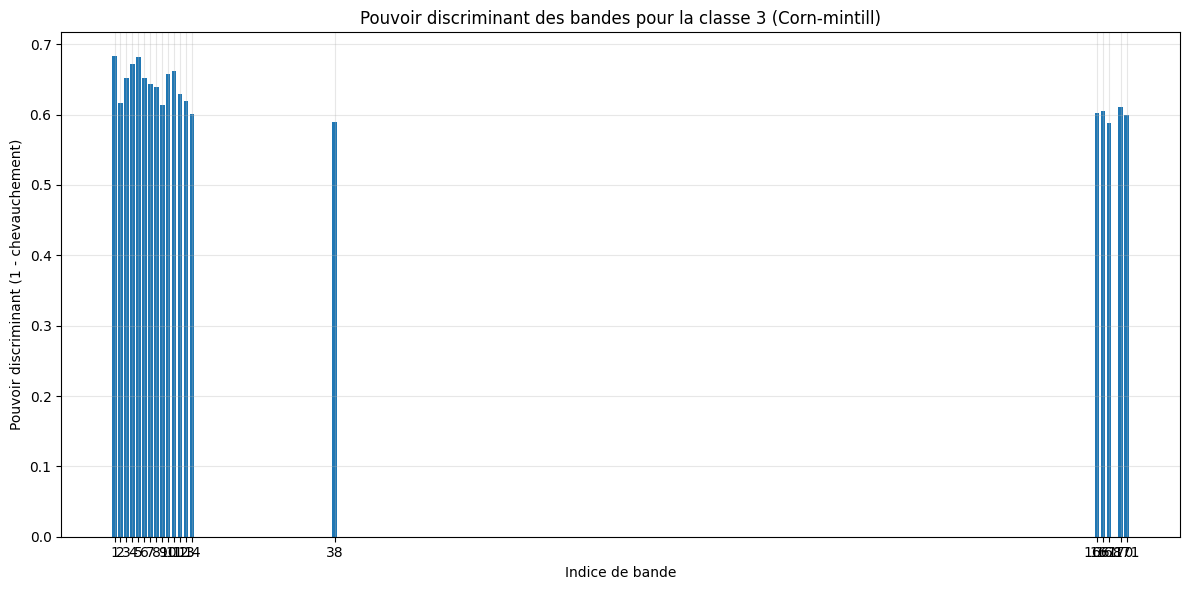

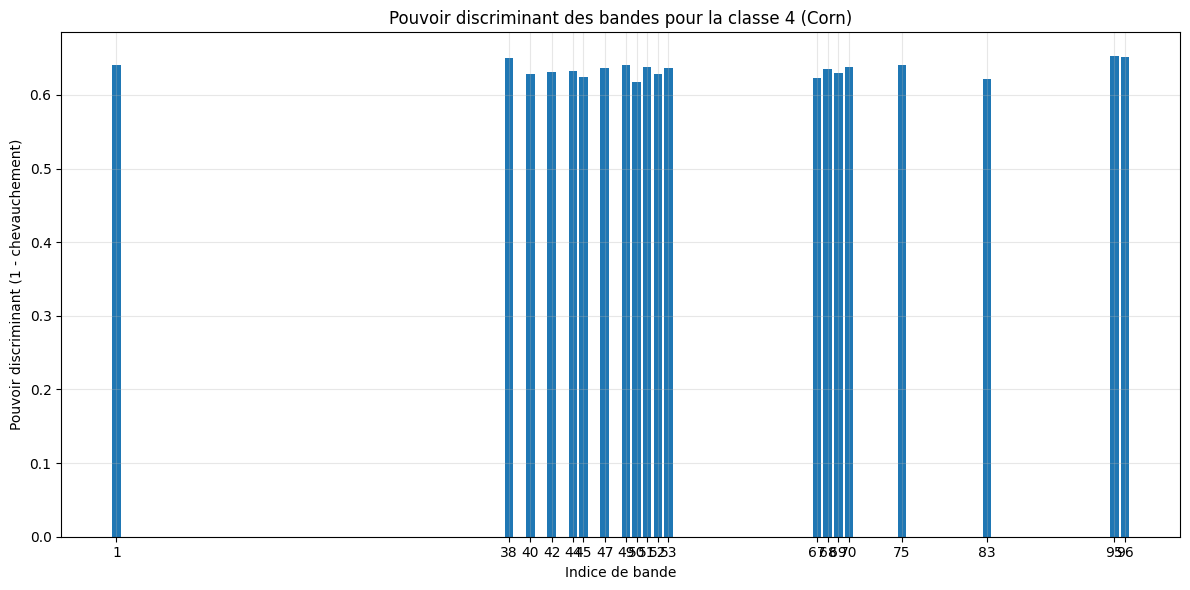

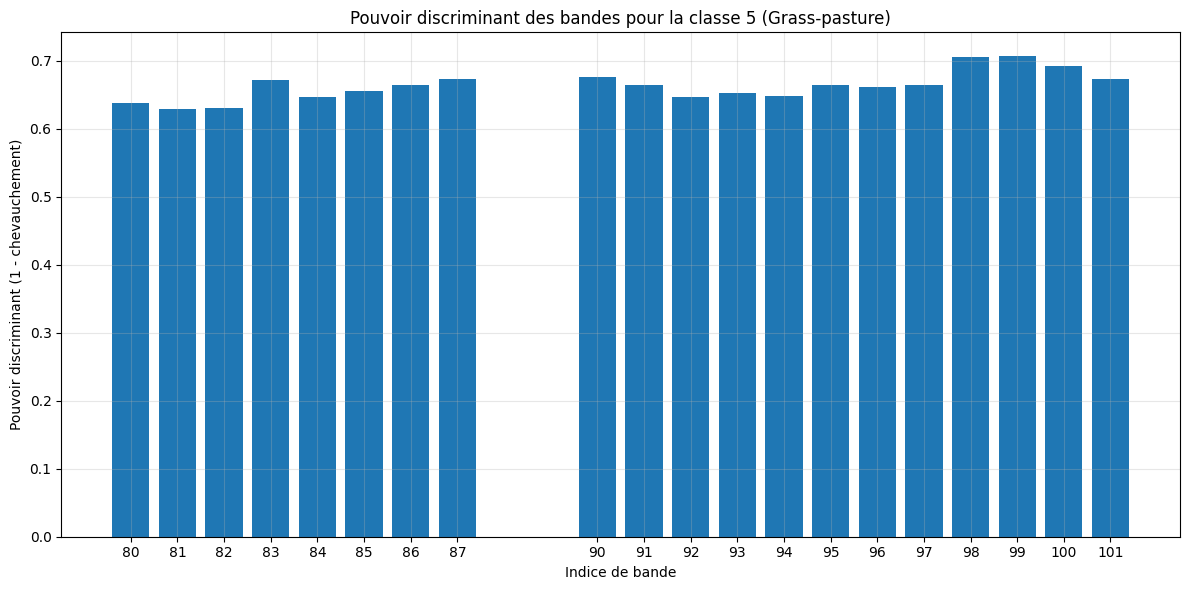

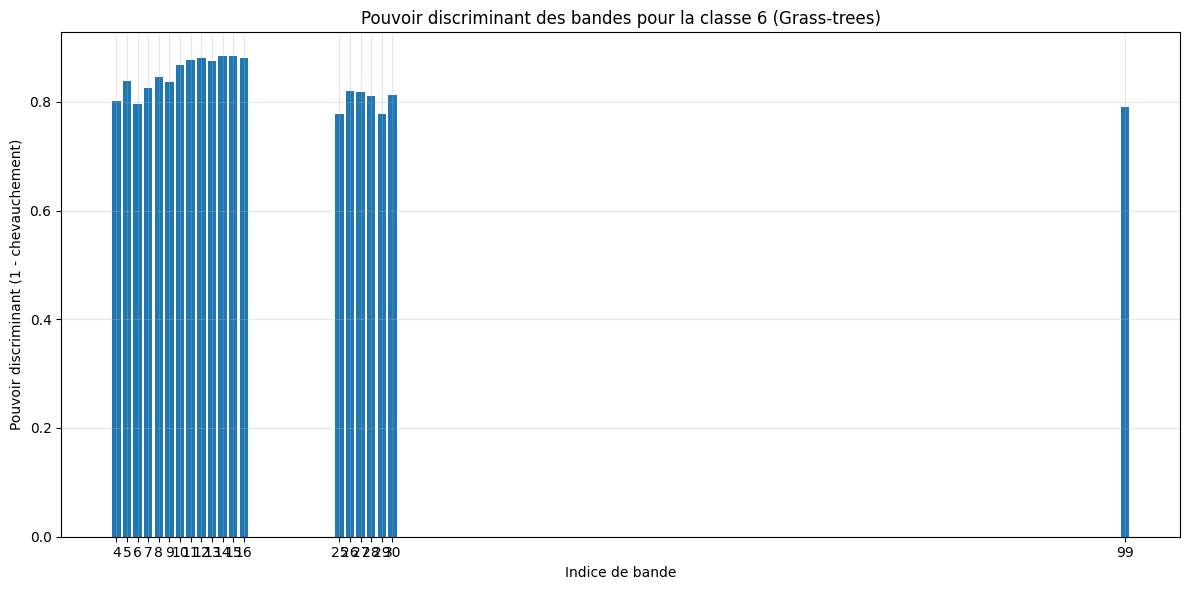

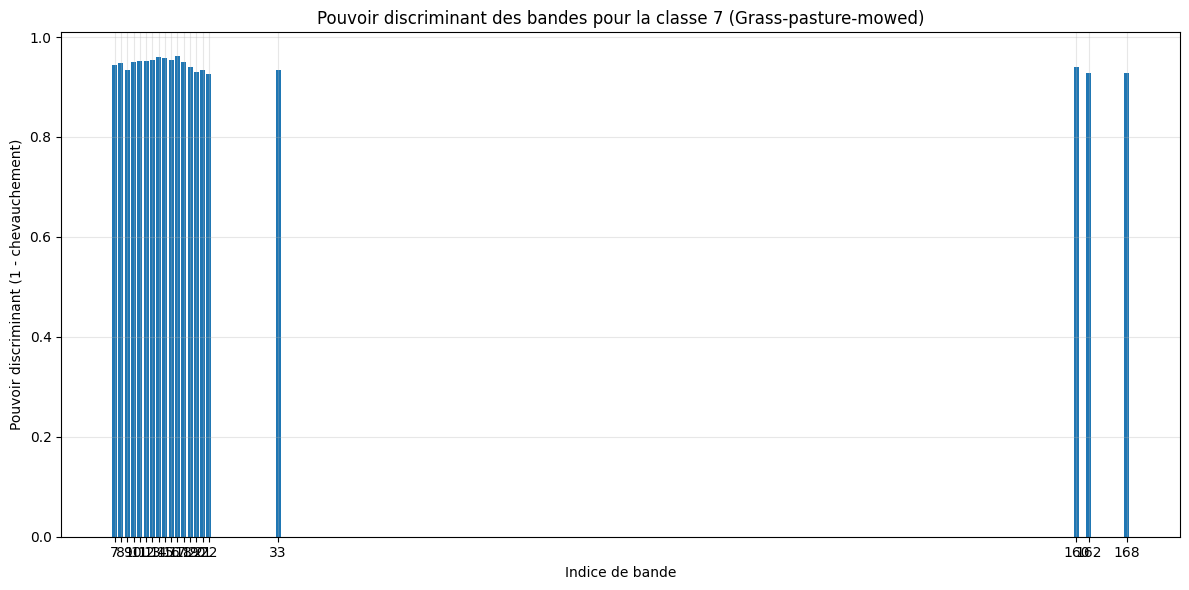

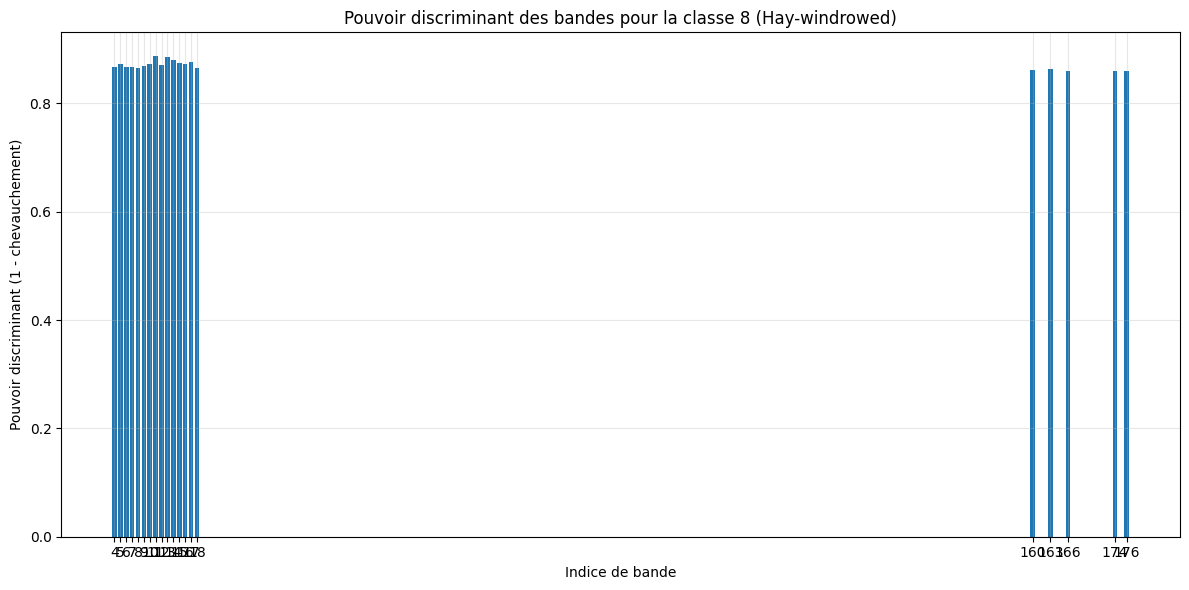

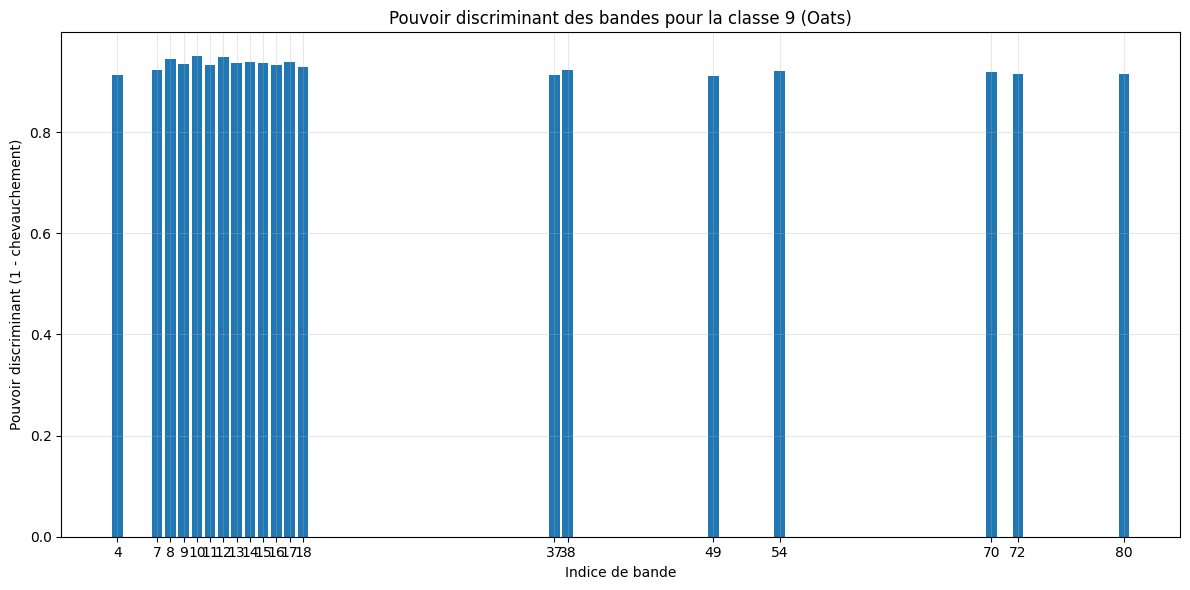

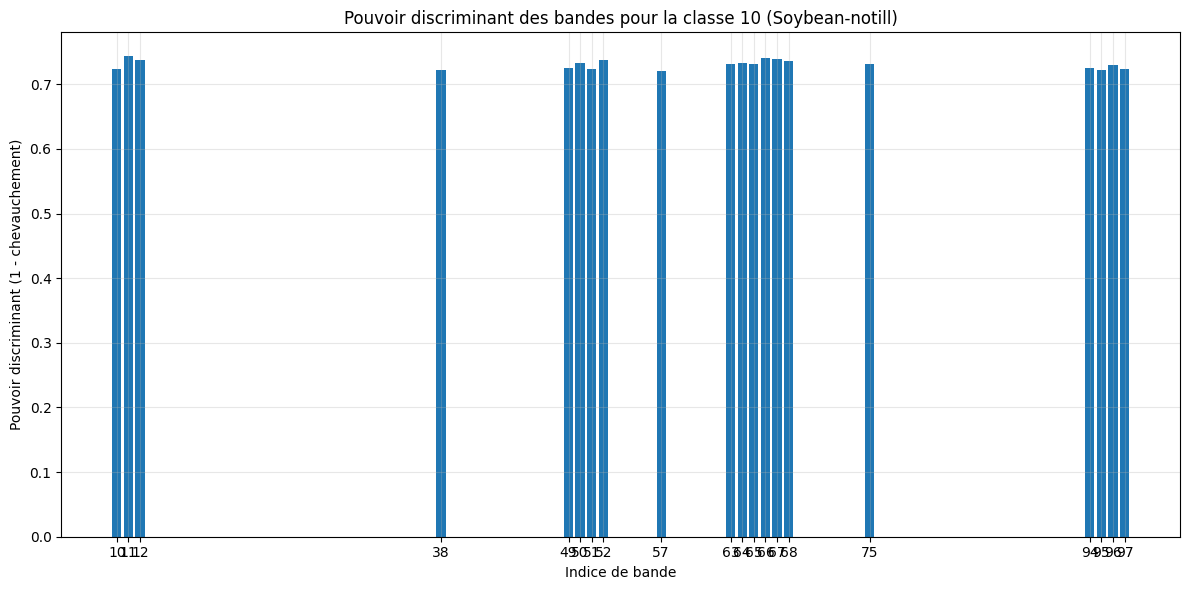

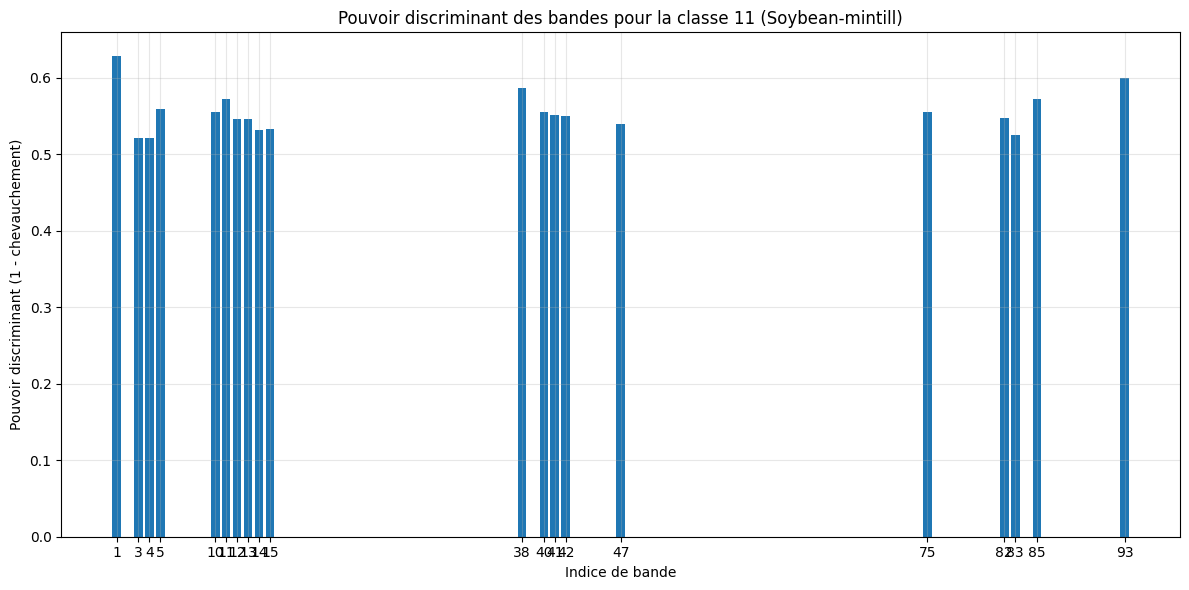

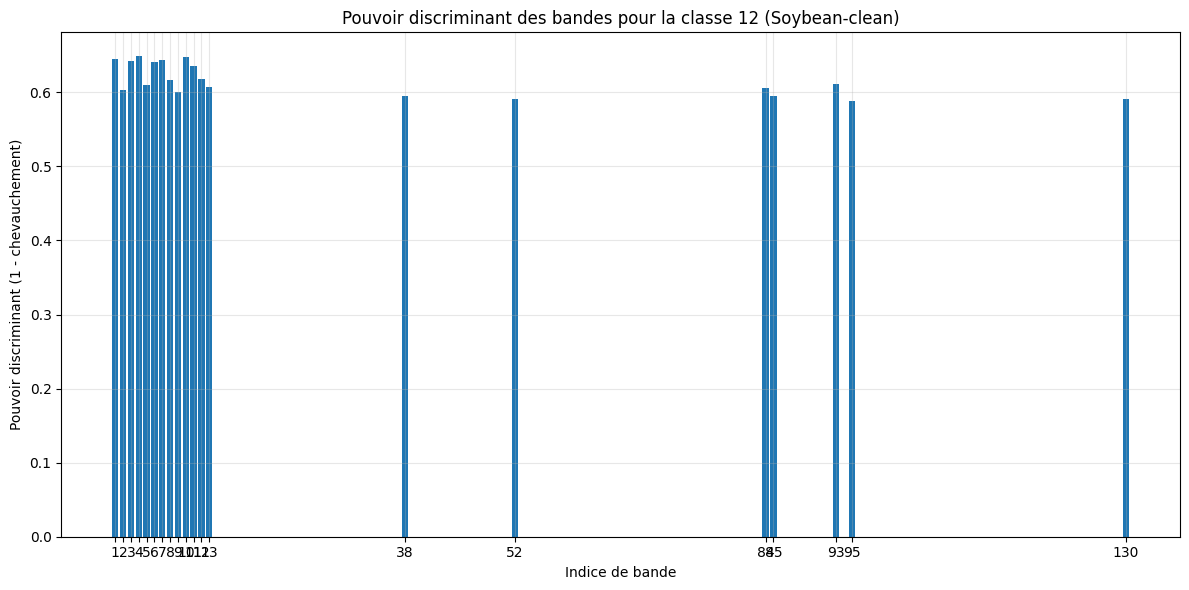

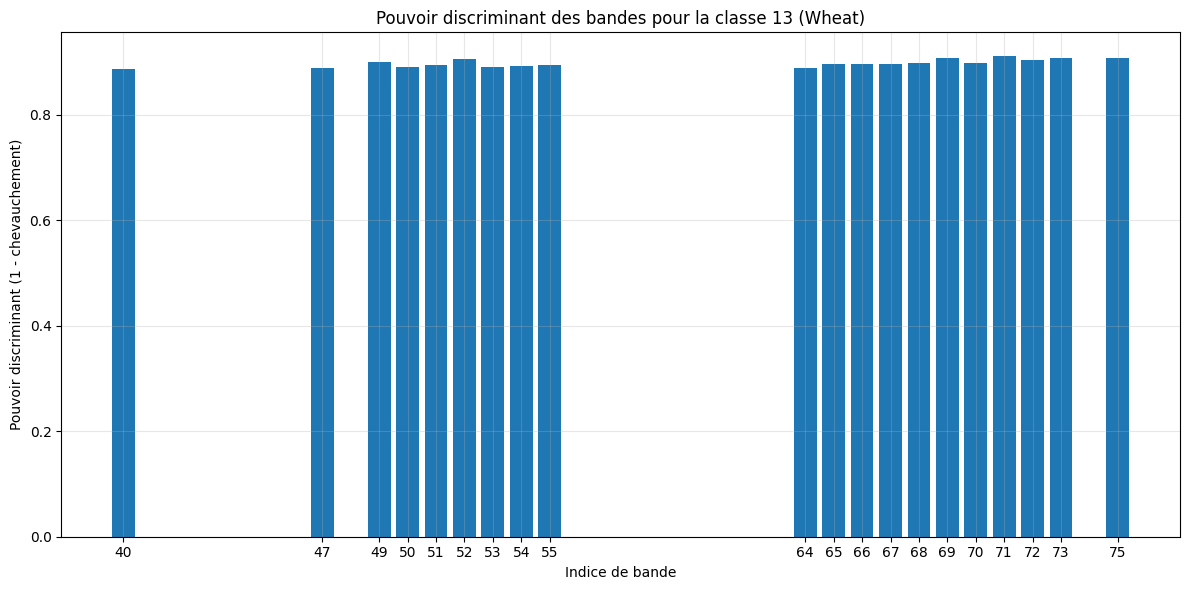

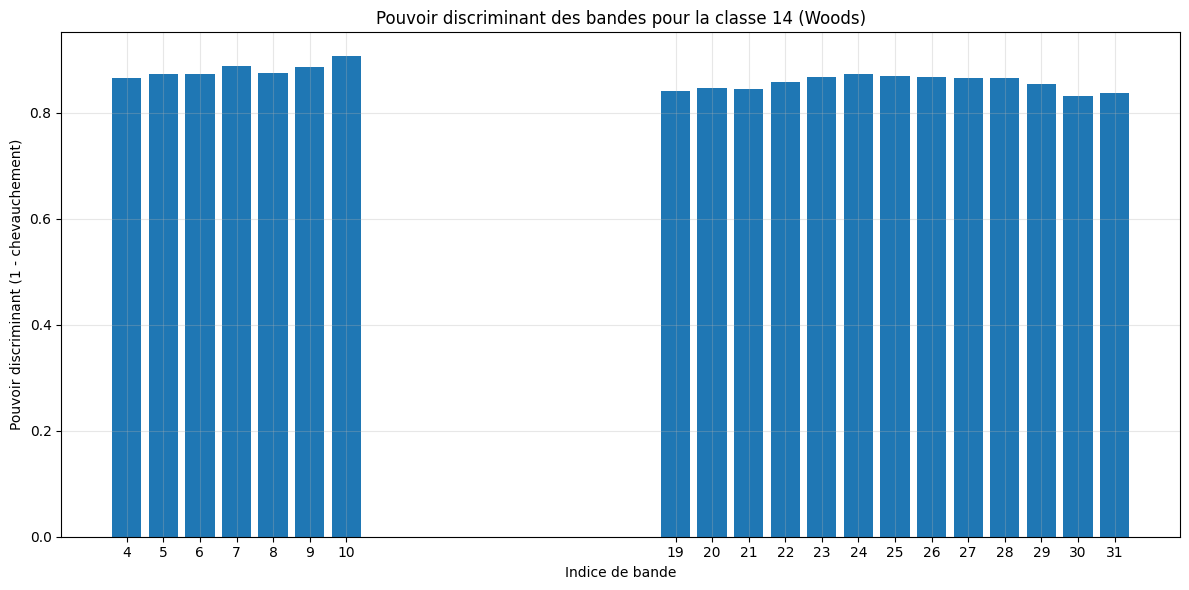

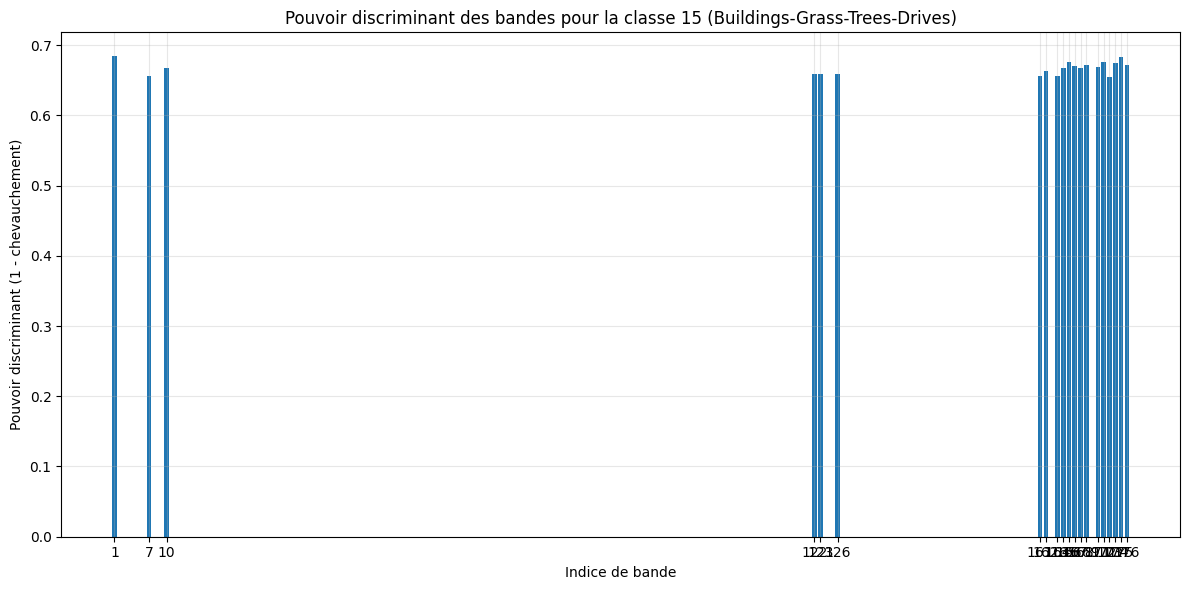

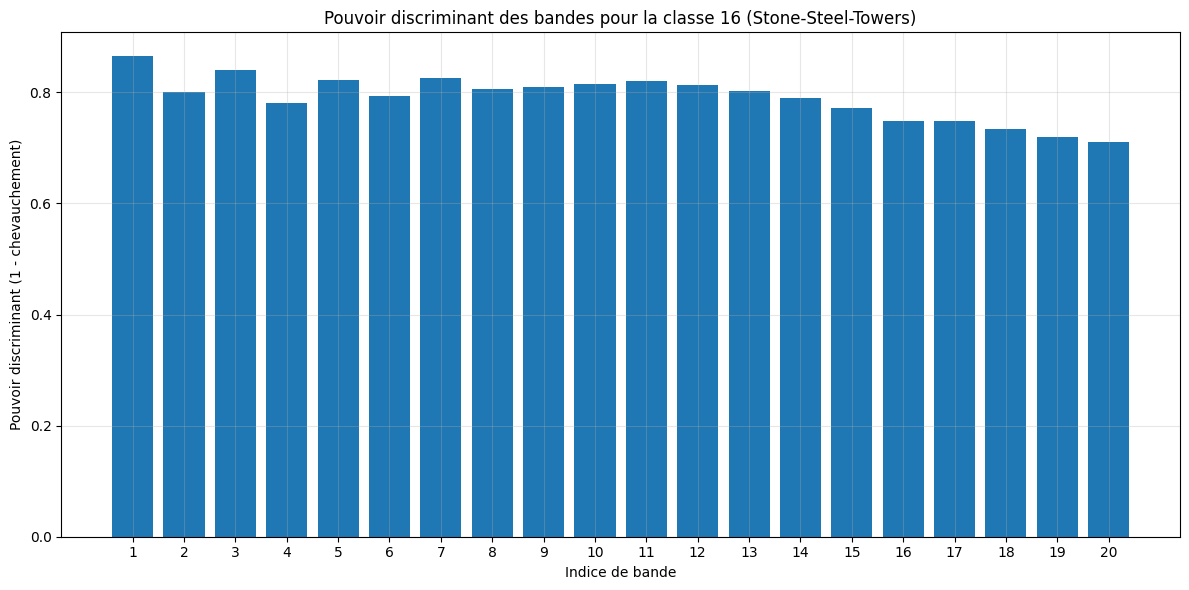

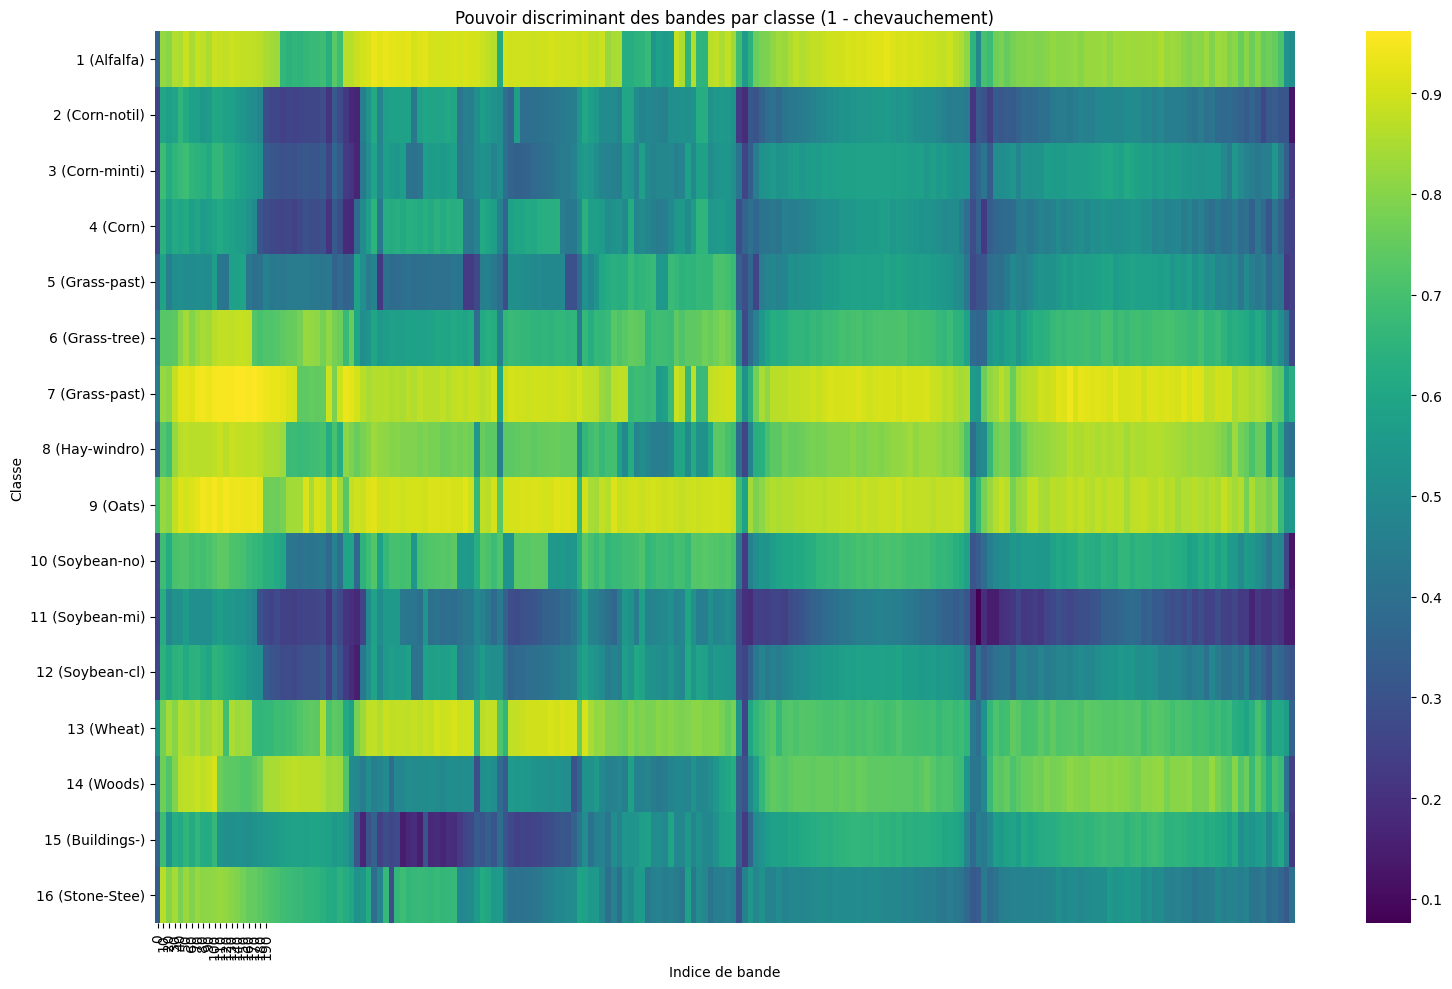


Les 10 bandes les plus discriminantes globalement:
 Bande  Pouvoir_discriminant
    10              0.757726
     5              0.744727
     7              0.741526
     4              0.736922
    11              0.733347
     8              0.729473
    13              0.728976
     9              0.726852
     6              0.725466
    14              0.721666


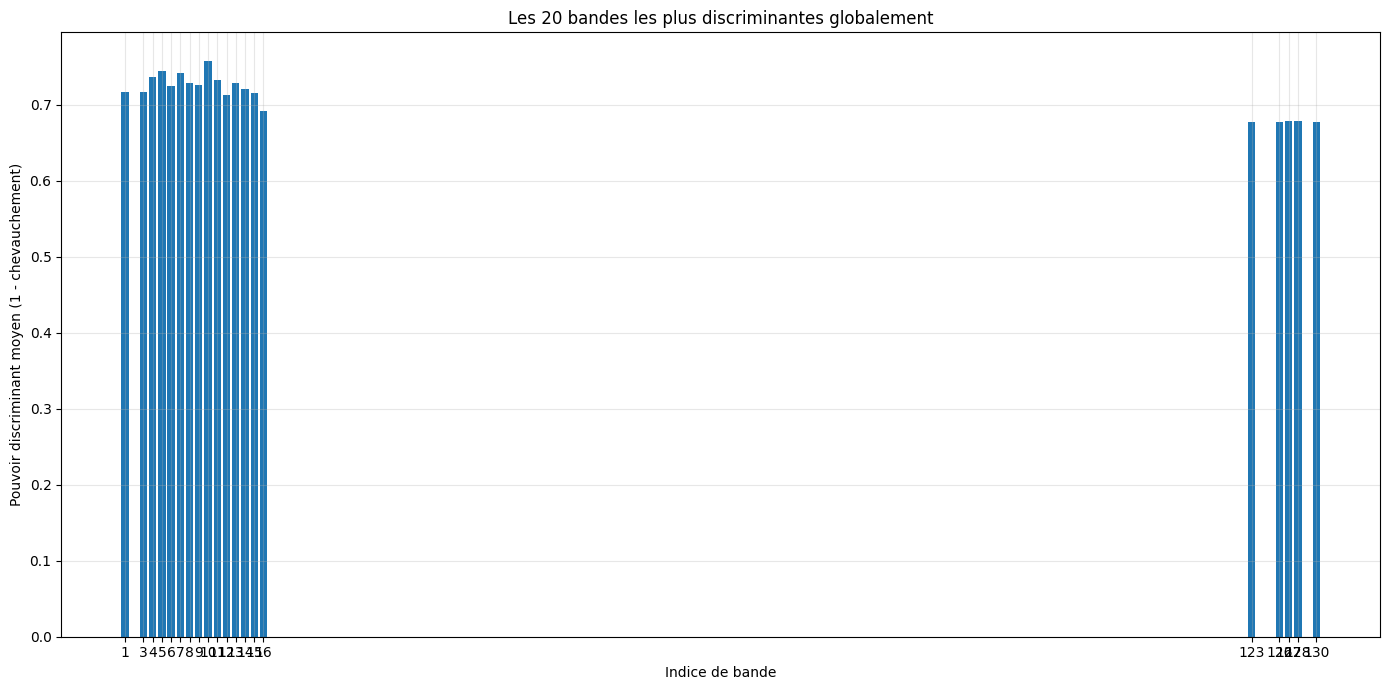

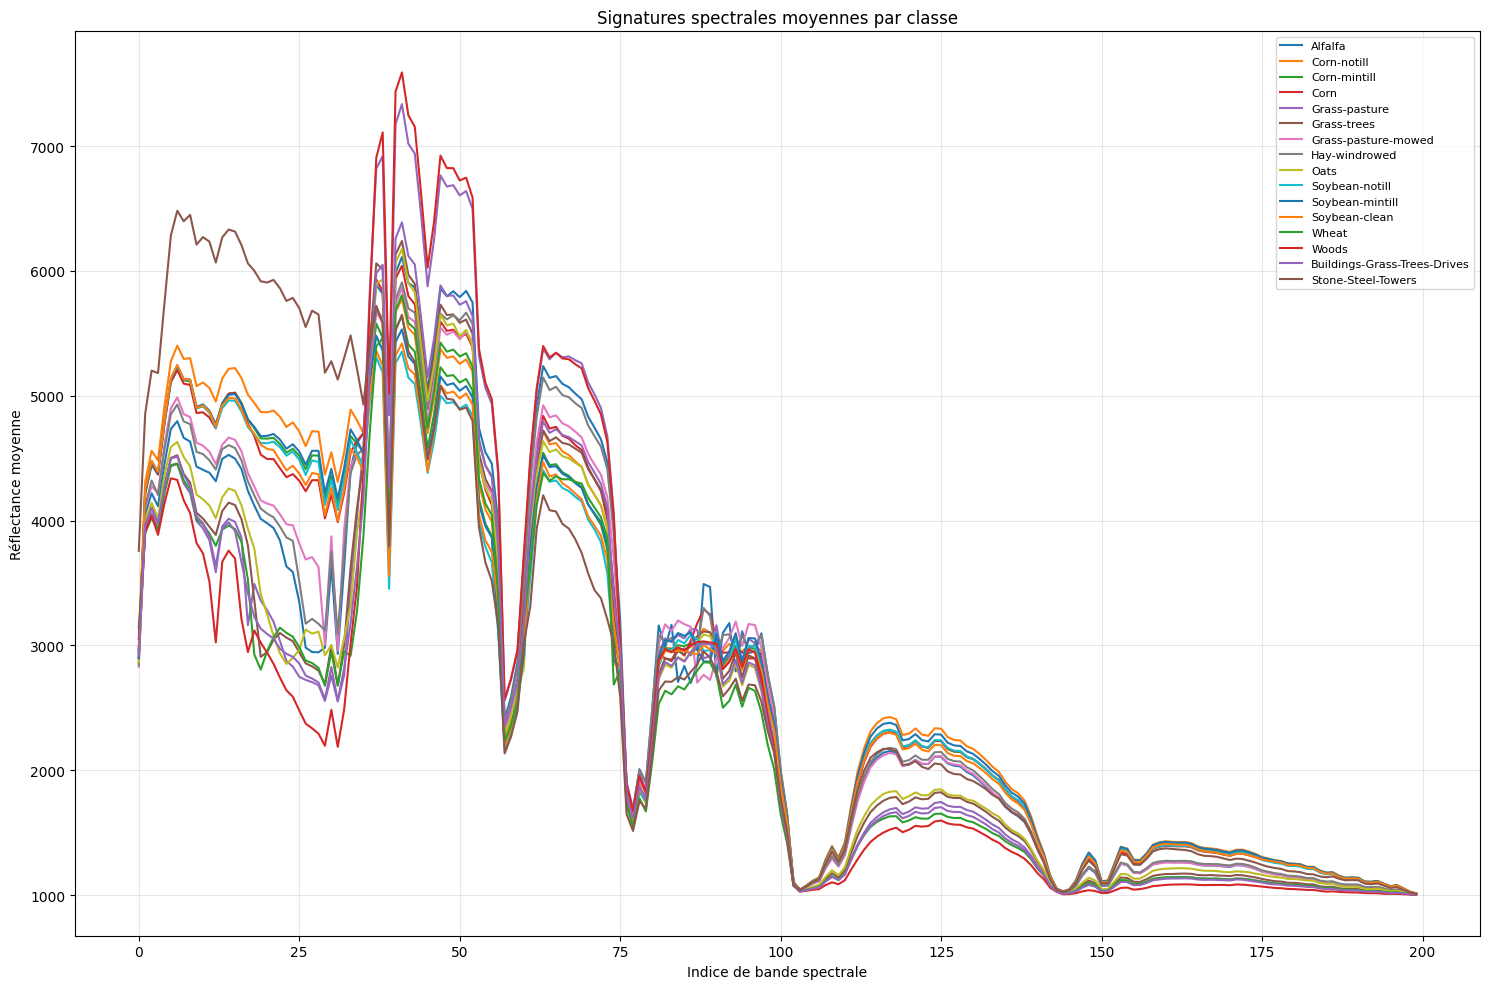

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os

# 1. Chargement des données
# Chemins vers les fichiers (ajustez selon votre environnement)
data_path = '/kaggle/input/piness/Indian_pines.mat'  # Données originales
corrected_data_path = '/kaggle/input/piness/Indian_pines_corrected.mat'  # Données corrigées
gt_path = '/kaggle/input/piness/Indian_pines_gt.mat'  # Vérité terrain

# Chargement des données
data = sio.loadmat(data_path)
corrected_data = sio.loadmat(corrected_data_path)
gt = sio.loadmat(gt_path)

# Extraire les données hyperspectrales et la vérité terrain
hyperspectral_data = corrected_data['indian_pines_corrected'] if 'indian_pines_corrected' in corrected_data else list(corrected_data.values())[3]
groundtruth = gt['indian_pines_gt'] if 'indian_pines_gt' in gt else list(gt.values())[3]

# Définir les noms des classes
class_names = [
    'Background',
    'Alfalfa',
    'Corn-notill',
    'Corn-mintill',
    'Corn',
    'Grass-pasture',
    'Grass-trees',
    'Grass-pasture-mowed',
    'Hay-windrowed',
    'Oats',
    'Soybean-notill',
    'Soybean-mintill',
    'Soybean-clean',
    'Wheat',
    'Woods',
    'Buildings-Grass-Trees-Drives',
    'Stone-Steel-Towers'
]

# Reshape les données pour faciliter l'analyse (chaque ligne = un pixel, chaque colonne = une bande)
pixels = hyperspectral_data.reshape(-1, hyperspectral_data.shape[2])
classes = groundtruth.flatten()

# Afficher les dimensions des données pour vérification
print(f"Dimensions de l'image: {hyperspectral_data.shape}")
print(f"Nombre de pixels: {pixels.shape[0]}")
print(f"Nombre de bandes spectrales: {pixels.shape[1]}")
print(f"Nombre de classes: {len(np.unique(classes))}")

# 2. Implémentation de l'algorithme de sélection des bandes discriminatives (one-vs-all)

def calculer_chevauchement(classe_A_min, classe_A_max, classe_B_min, classe_B_max):
    """
    Calcule le chevauchement entre deux plages de valeurs.
    
    Args:
        classe_A_min, classe_A_max: Valeurs min et max pour la classe A
        classe_B_min, classe_B_max: Valeurs min et max pour la classe B
    
    Returns:
        Chevauchement normalisé (0 signifie aucun chevauchement, valeur positive indique un chevauchement)
    """
    # Calcul des bornes de chevauchement
    a = max(classe_A_min, classe_B_min)  # La plus grande des valeurs minimales
    b = min(classe_A_max, classe_B_max)  # La plus petite des valeurs maximales
    
    # Calcul du chevauchement brut
    c = b - a
    
    # Calcul de l'étendue totale
    etendue_totale = max(classe_A_max, classe_B_max) - min(classe_A_min, classe_B_min)
    
    # Normalisation du chevauchement
    if etendue_totale > 0:
        c_normalise = c / etendue_totale
    else:
        c_normalise = 0
    
    # Retourne max(0, c_normalise)
    return max(0, c_normalise)

# Exclure les pixels avec classe 0 (généralement le fond)
mask = classes > 0
valid_pixels = pixels[mask]
valid_classes = classes[mask]

# Obtenir la liste des classes uniques (sauf le fond)
classes_uniques = sorted(np.unique(valid_classes))

# Vérifier les classes disponibles
print(f"Classes disponibles (sans le fond): {classes_uniques}")

# Créer un DataFrame pour stocker les résultats
resultats_onevsall = pd.DataFrame(columns=['Classe', 'Bande', 'Chevauchement'])

# Boucle sur chaque classe
for classe in classes_uniques:
    print(f"Traitement de la classe {classe} ({class_names[classe] if classe < len(class_names) else 'Non nommée'})...")
    
    # Créer le masque pour la classe actuelle et pour toutes les autres classes
    mask_classe = valid_classes == classe
    mask_autres = valid_classes != classe
    
    # Boucle sur chaque bande spectrale
    for bande in range(pixels.shape[1]):
        # Extraire les valeurs de la bande pour la classe actuelle et toutes les autres
        valeurs_classe = valid_pixels[mask_classe, bande]
        valeurs_autres = valid_pixels[mask_autres, bande]
        
        # Calculer les min et max pour la classe et les autres
        classe_min = np.min(valeurs_classe)
        classe_max = np.max(valeurs_classe)
        autres_min = np.min(valeurs_autres)
        autres_max = np.max(valeurs_autres)
        
        # Calculer le chevauchement normalisé
        chevauchement = calculer_chevauchement(classe_min, classe_max, autres_min, autres_max)
        
        # Stocker les résultats
        nouvelle_ligne = {
            'Classe': int(classe),  # Assurez-vous que Classe est un entier
            'Bande': int(bande),    # Assurez-vous que Bande est un entier
            'Chevauchement': float(chevauchement)  # Assurez-vous que Chevauchement est un float
        }
        resultats_onevsall = pd.concat([resultats_onevsall, pd.DataFrame([nouvelle_ligne])], ignore_index=True)

# Convertir les colonnes en types appropriés
resultats_onevsall['Classe'] = resultats_onevsall['Classe'].astype(int)
resultats_onevsall['Bande'] = resultats_onevsall['Bande'].astype(int)
resultats_onevsall['Chevauchement'] = resultats_onevsall['Chevauchement'].astype(float)

# Identifier les bandes les plus discriminantes pour chaque classe
# (Celles avec le chevauchement le plus faible sont les plus discriminantes)
meilleures_bandes_par_classe = resultats_onevsall.sort_values(['Classe', 'Chevauchement']).groupby('Classe').head(5)

# Afficher les résultats
print("\nLes 5 bandes les plus discriminantes pour chaque classe (approche one-vs-all):")
for classe in classes_uniques:
    print(f"\nClasse {classe} ({class_names[classe] if classe < len(class_names) else 'Non nommée'}):")
    resultats_classe = meilleures_bandes_par_classe[meilleures_bandes_par_classe['Classe'] == classe]
    print(resultats_classe[['Bande', 'Chevauchement']].to_string(index=False))

# Visualiser les résultats pour chaque classe
for classe in classes_uniques:
    # Sélectionner les résultats pour cette classe
    resultats_classe = resultats_onevsall[resultats_onevsall['Classe'] == classe]
    
    # Trier par chevauchement (du plus petit au plus grand)
    resultats_classe = resultats_classe.sort_values('Chevauchement')
    
    # Visualiser les 20 meilleures bandes
    plt.figure(figsize=(12, 6))
    top_20_bandes = resultats_classe.head(20)
    
    #  Convertir les valeurs de bande en liste d'entiers pour xticks
    bandes_liste = top_20_bandes['Bande'].astype(int).tolist()
    pouvoir_discriminant = (1 - top_20_bandes['Chevauchement']).tolist()
    
    # Créer le graphique avec les listes
    plt.bar(bandes_liste, pouvoir_discriminant)
    plt.title(f'Pouvoir discriminant des bandes pour la classe {classe} ({class_names[classe] if classe < len(class_names) else "Non nommée"})')
    plt.xlabel('Indice de bande')
    plt.ylabel('Pouvoir discriminant (1 - chevauchement)')
    plt.xticks(bandes_liste)  # Utiliser la liste d'entiers
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    try:
        plt.savefig(f'pouvoir_discriminant_classe_{classe}.png')
        plt.show()  # MODIFICATION: Afficher le graphique
        plt.close()  # Fermer la figure pour économiser la mémoire
    except Exception as e:
        print(f"Erreur lors de la sauvegarde du graphique pour la classe {classe}: {e}")
        plt.close()

# Créer une heatmap globale du pouvoir discriminant des bandes pour toutes les classes
# Créer une matrice où chaque ligne est une classe et chaque colonne est une bande
matrice_discriminante = np.zeros((len(classes_uniques), pixels.shape[1]))

for i, classe in enumerate(classes_uniques):
    resultats_classe = resultats_onevsall[resultats_onevsall['Classe'] == classe]
    for _, row in resultats_classe.iterrows():
        matrice_discriminante[i, int(row['Bande'])] = 1 - row['Chevauchement']

# Créer la heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(matrice_discriminante, cmap='viridis', 
            xticklabels=list(range(0, pixels.shape[1], 10)),  # Utiliser list() pour créer une liste Python
            yticklabels=[f"{int(classe)} ({class_names[int(classe)][:10]})" for classe in classes_uniques])
plt.title('Pouvoir discriminant des bandes par classe (1 - chevauchement)')
plt.xlabel('Indice de bande')
plt.ylabel('Classe')
plt.tight_layout()

try:
    plt.savefig('heatmap_pouvoir_discriminant.png')
    plt.show()  
    plt.close()
except Exception as e:
    print(f"Erreur lors de la sauvegarde de la heatmap: {e}")
    plt.close()

# Identifier les bandes globalement les plus discriminantes
# Calculer le score moyen de discrimination pour chaque bande (toutes classes confondues)
score_moyen_bandes = resultats_onevsall.groupby('Bande')['Chevauchement'].mean().reset_index()
score_moyen_bandes['Pouvoir_discriminant'] = 1 - score_moyen_bandes['Chevauchement']
score_moyen_bandes = score_moyen_bandes.sort_values('Pouvoir_discriminant', ascending=False)

# Afficher les 10 meilleures bandes globalement
print("\nLes 10 bandes les plus discriminantes globalement:")
print(score_moyen_bandes.head(10)[['Bande', 'Pouvoir_discriminant']].to_string(index=False))

# Visualiser les résultats globaux
plt.figure(figsize=(14, 7))
#  Convertir en listes Python pour éviter les erreurs de type
top_bandes = score_moyen_bandes.head(20)['Bande'].astype(int).tolist()
pouvoir_disc = score_moyen_bandes.head(20)['Pouvoir_discriminant'].tolist()

plt.bar(top_bandes, pouvoir_disc)
plt.title('Les 20 bandes les plus discriminantes globalement')
plt.xlabel('Indice de bande')
plt.ylabel('Pouvoir discriminant moyen (1 - chevauchement)')
plt.grid(alpha=0.3)
plt.xticks(top_bandes)  # Utiliser la liste d'entiers
plt.tight_layout()

try:
    plt.savefig('bandes_discriminantes_global.png')
    plt.show()  
    plt.close()
except Exception as e:
    print(f"Erreur lors de la sauvegarde du graphique global: {e}")
    plt.close()

# Visualiser les signatures spectrales moyennes par classe
plt.figure(figsize=(15, 10))
# Calculer et tracer la signature spectrale moyenne pour chaque classe (sauf le fond)
for classe in classes_uniques:
    # Récupérer tous les pixels de cette classe
    class_pixels = valid_pixels[valid_classes == classe]
    # Calculer la signature spectrale moyenne
    mean_spectrum = np.mean(class_pixels, axis=0)
    # Tracer la signature moyenne
    plt.plot(range(mean_spectrum.shape[0]), mean_spectrum, 
             label=class_names[int(classe)] if int(classe) < len(class_names) else f"Classe {int(classe)}")
plt.title('Signatures spectrales moyennes par classe')
plt.xlabel('Indice de bande spectrale')
plt.ylabel('Réflectance moyenne')
plt.grid(alpha=0.3)
plt.legend(loc='best', fontsize=8)
plt.tight_layout()

try:
    plt.savefig('signatures_spectrales_moyennes.png')
    plt.show() 
    plt.close()
except Exception as e:
    print(f"Erreur lors de la sauvegarde des signatures spectrales: {e}")
    plt.close()

# Export des résultats dans un fichier CSV
meilleures_bandes_par_classe.to_csv('meilleures_bandes_par_classe.csv', index=False)
score_moyen_bandes.to_csv('bandes_discriminantes_global.csv', index=False)

In [3]:
# 6. Classification par modèles de machine learning avec sélection de bandes optimales
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import time

print("Configuration de TensorFlow...")
# Configuration des GPUs si disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU disponible, utilisation du CPU")

# 6.1 Préparation des données pour la classification
print("\n=== Préparation des données ===")
mask = classes > 0
X = pixels[mask]  # Données originales (200 bandes)
y = classes[mask]  # Classes (étiquettes)

# 6.2 Création d'un modèle MLP avec BatchNormalization
def creer_modele_mlp(input_dim):
    """
    Crée un modèle MLP avec l'architecture spécifiée et BatchNormalization
    """
    inputs = Input(shape=(input_dim,))
    
    # Couche d'entrée
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    
    # Deuxième couche
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Troisième couche
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Quatrième couche
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Couche de sortie (binaire)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 6.3 Fonction de visualisation des courbes d'apprentissage
def visualiser_courbes_apprentissage(history, classe, classe_nom, methode):
    """
    Visualise et sauvegarde les courbes d'apprentissage d'un modèle.
    """
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - Classe {classe} ({classe_nom}) - {methode}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - Classe {classe} ({classe_nom}) - {methode}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'learning_curves_classe_{classe}_{methode}.png')
    plt.close()

# 6.4 Fonction d'entraînement et d'évaluation d'un modèle binaire
def entrainer_evaluer_modele(X_train, y_train, X_test, y_test, classe_id, classe_nom, methode_selection):
    """
    Entraîne et évalue un modèle MLP pour une classification binaire.
    """
    print(f"Entraînement du modèle pour la classe {classe_id} ({classe_nom}) - Méthode: {methode_selection}")
    
    # Créer le modèle
    nb_bandes = X_train.shape[1]
    model = creer_modele_mlp(input_dim=nb_bandes)
    
    # Early stopping pour éviter l'overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    # Mesurer le temps d'entraînement
    start_time = time.time()
    
    # Entraîner le modèle
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    
    train_time = time.time() - start_time
    
    # Visualiser les courbes d'apprentissage
    visualiser_courbes_apprentissage(history, classe_id, classe_nom, methode_selection)
    
    # Évaluer le modèle
    start_time = time.time()
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    predict_time = time.time() - start_time
    
    # Générer les prédictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype("int32").flatten()
    
    # Calculer les métriques
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Courbe ROC et AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Afficher un résumé des performances
    print(f"  Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, AUC: {roc_auc:.4f}")
    print(f"  Temps d'entraînement: {train_time:.2f}s, Temps de prédiction: {predict_time:.2f}s")
    
    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - Classe {classe_id} ({classe_nom}) - {methode_selection}')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_classe_{classe_id}_{methode_selection}.png')
    plt.close()
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - Classe {classe_id} ({classe_nom}) - {methode_selection}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.savefig(f'confusion_matrix_classe_{classe_id}_{methode_selection}.png')
    plt.close()
    
    return {
        'classe_id': classe_id,
        'classe_nom': classe_nom,
        'methode': methode_selection,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'train_time': train_time,
        'predict_time': predict_time,
        'model': model,
        'history': history
    }

# 6.5 Première méthode: Top 10 des bandes les plus discriminantes pour chaque classe
def selectionner_top10_bandes(classe):
    """
    Sélectionne les 10 bandes les plus discriminantes pour une classe donnée.
    """
    # Trier les bandes par chevauchement croissant (pouvoir discriminant décroissant)
    bandes_triees = resultats_onevsall[resultats_onevsall['Classe'] == classe].sort_values('Chevauchement')
    
    # Sélectionner les 10 meilleures
    top10_bandes = bandes_triees.head(10)['Bande'].values
    
    return top10_bandes

# 6.6 Deuxième méthode: Sélection de bandes par ranges
def selectionner_bandes_par_ranges(classe, nb_ranges=8, bandes_par_range=1):
    """
    Sélectionne les bandes discriminantes pour une classe en assurant la représentation de différents ranges spectraux.
    """
    nb_bandes_total = pixels.shape[1]
    taille_range = nb_bandes_total // nb_ranges
    
    bandes_selectionnees = []
    
    # Pour chaque range spectral
    for i in range(nb_ranges):
        debut = i * taille_range
        fin = (i+1) * taille_range - 1 if i < nb_ranges-1 else nb_bandes_total-1
        
        # Filtrer les résultats pour cette classe et ce range
        filtre = (resultats_onevsall['Classe'] == classe) & (resultats_onevsall['Bande'] >= debut) & (resultats_onevsall['Bande'] <= fin)
        
        # Sélectionner les meilleures bandes de ce range
        meilleures_du_range = resultats_onevsall[filtre].sort_values('Chevauchement').head(bandes_par_range)['Bande'].values
        
        bandes_selectionnees.extend(meilleures_du_range)
    
    return np.array(bandes_selectionnees)

# 6.7 Entraînement des modèles pour chaque classe avec les deux méthodes
resultats_top10 = []
resultats_ranges = []

for classe in classes_uniques:
    classe_nom = class_names[classe] if classe < len(class_names) else f"Classe {classe}"
    
    print(f"\n=== Traitement de la classe {classe} ({classe_nom}) ===")
    
    # 6.7.1 Créer les étiquettes binaires pour cette classe
    y_binaire = np.where(y == classe, 1, 0)
    
    # 6.7.2 Sélection par Top 10
    top10_bandes = selectionner_top10_bandes(classe)
    print(f"Top 10 bandes pour la classe {classe}: {top10_bandes}")
    
    # Préparer les données avec les bandes sélectionnées
    X_selected_top10 = X[:, top10_bandes]
    
    # Standardiser
    scaler_top10 = StandardScaler()
    X_scaled_top10 = scaler_top10.fit_transform(X_selected_top10)
    
    # Diviser en ensembles d'entraînement et de test
    X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(
        X_scaled_top10, y_binaire, test_size=0.3, random_state=42, stratify=y_binaire
    )
    
    # Entraîner et évaluer le modèle Top 10
    resultat_top10 = entrainer_evaluer_modele(
        X_train_top10, y_train_top10, 
        X_test_top10, y_test_top10,
        classe, classe_nom, "top10"
    )
    resultat_top10['bandes_selectionnees'] = top10_bandes
    resultats_top10.append(resultat_top10)
    
    # 6.7.3 Sélection par ranges
    # Diviser le spectre en 8 ranges et sélectionner 1 bande par range (total 8 bandes)
    bandes_ranges = selectionner_bandes_par_ranges(classe, nb_ranges=8, bandes_par_range=1)
    print(f"Bandes sélectionnées par ranges pour la classe {classe}: {bandes_ranges}")
    
    # Préparer les données avec les bandes sélectionnées
    X_selected_ranges = X[:, bandes_ranges]
    
    # Standardiser
    scaler_ranges = StandardScaler()
    X_scaled_ranges = scaler_ranges.fit_transform(X_selected_ranges)
    
    # Diviser en ensembles d'entraînement et de test
    X_train_ranges, X_test_ranges, y_train_ranges, y_test_ranges = train_test_split(
        X_scaled_ranges, y_binaire, test_size=0.3, random_state=42, stratify=y_binaire
    )
    
    # Entraîner et évaluer le modèle par ranges
    resultat_ranges = entrainer_evaluer_modele(
        X_train_ranges, y_train_ranges,
        X_test_ranges, y_test_ranges,
        classe, classe_nom, "ranges"
    )
    resultat_ranges['bandes_selectionnees'] = bandes_ranges
    resultats_ranges.append(resultat_ranges)

# 6.8 Compilation et analyse des résultats
print("\n=== Compilation des résultats ===")

# Créer des DataFrames pour les résultats
df_resultats_top10 = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'AUC': r['auc'],
        'Temps_entraînement(s)': r['train_time'],
        'Nb_bandes': len(r['bandes_selectionnees'])
    }
    for r in resultats_top10
])

df_resultats_ranges = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'AUC': r['auc'],
        'Temps_entraînement(s)': r['train_time'],
        'Nb_bandes': len(r['bandes_selectionnees'])
    }
    for r in resultats_ranges
])

# Combinaison des résultats pour comparaison
df_tous_resultats = pd.concat([df_resultats_top10, df_resultats_ranges])

# Afficher les résultats
print("\nRésultats avec la méthode Top 10:")
print(df_resultats_top10.sort_values('F1', ascending=False))

print("\nRésultats avec la méthode par ranges:")
print(df_resultats_ranges.sort_values('F1', ascending=False))

# 6.9 Visualisations comparatives
print("\n=== Création des visualisations comparatives ===")

# 6.9.1 Comparaison des performances par classe et par méthode
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Créer un barplot pour comparer les métriques F1 des deux méthodes
ax = sns.barplot(
    data=df_tous_resultats,
    x='Classe',
    y='F1',
    hue='Méthode',
    palette=['blue', 'green']
)

plt.title('Comparaison des scores F1 par classe et par méthode de sélection')
plt.xlabel('Classe')
plt.ylabel('Score F1')
plt.xticks(rotation=90)
plt.legend(title='Méthode', loc='lower right')
plt.tight_layout()
plt.savefig('comparaison_f1_par_classe_et_methode.png')
plt.close()

# 6.9.2 Comparaison des performances moyennes par méthode
plt.figure(figsize=(12, 8))

# Calculer les moyennes par méthode
metriques_moyennes = df_tous_resultats.groupby('Méthode')[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].mean().reset_index()

# Transformer pour faciliter la visualisation
metriques_moyennes_melted = pd.melt(
    metriques_moyennes,
    id_vars=['Méthode'],
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'],
    var_name='Métrique',
    value_name='Valeur'
)

# Créer le barplot
sns.barplot(
    data=metriques_moyennes_melted,
    x='Métrique',
    y='Valeur',
    hue='Méthode',
    palette=['blue', 'green']
)

plt.title('Comparaison des performances moyennes par méthode de sélection')
plt.xlabel('Métrique')
plt.ylabel('Valeur moyenne')
plt.ylim(0, 1)
plt.legend(title='Méthode')
plt.tight_layout()
plt.savefig('comparaison_performances_moyennes.png')
plt.close()

# 6.9.3 Comparaison des temps d'entraînement
plt.figure(figsize=(14, 8))

# Créer le barplot pour les temps d'entraînement
sns.barplot(
    data=df_tous_resultats,
    x='Classe',
    y='Temps_entraînement(s)',
    hue='Méthode',
    palette=['blue', 'green']
)

plt.title('Comparaison des temps d\'entraînement par classe et par méthode')
plt.xlabel('Classe')
plt.ylabel('Temps d\'entraînement (secondes)')
plt.xticks(rotation=90)
plt.legend(title='Méthode')
plt.tight_layout()
plt.savefig('comparaison_temps_entrainement.png')
plt.close()

# 6.10 Créer une visualisation de toutes les courbes de learning pour comparaison
print("\n=== Création de la comparaison globale des courbes d'apprentissage ===")

# 6.10.1 Comparaison des courbes d'apprentissage pour une métrique (accuracy)
plt.figure(figsize=(16, 12))
plt.suptitle('Comparaison des courbes d\'accuracy de validation par classe et méthode', fontsize=16)

for i, classe in enumerate(classes_uniques):
    classe_nom = class_names[classe] if classe < len(class_names) else f"Classe {classe}"
    plt.subplot(4, 4, i+1)  # 4x4 grid pour les 16 classes
    
    # Récupérer l'historique pour la méthode top10
    histoire_top10 = next(r['history'] for r in resultats_top10 if r['classe_id'] == classe)
    # Récupérer l'historique pour la méthode ranges
    histoire_ranges = next(r['history'] for r in resultats_ranges if r['classe_id'] == classe)
    
    # Tracer les courbes d'accuracy de validation
    plt.plot(histoire_top10.history['val_accuracy'], 'b-', label='Top10')
    plt.plot(histoire_ranges.history['val_accuracy'], 'g-', label='Ranges')
    
    plt.title(f'Classe {classe} ({classe_nom[:10]})')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.grid(True, alpha=0.3)
    if i == 0:  # Ajouter la légende seulement pour le premier subplot
        plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajuster pour le titre global
plt.savefig('comparaison_globale_courbes_apprentissage.png')
plt.close()

# 6.11 Sauvegarder les résultats et les modèles
print("\n=== Sauvegarde des résultats ===")

# Sauvegarder les résultats en CSV
df_resultats_top10.to_csv('resultats_top10.csv', index=False)
df_resultats_ranges.to_csv('resultats_ranges.csv', index=False)
df_tous_resultats.to_csv('tous_resultats.csv', index=False)

# Sauvegarder les informations sur les bandes sélectionnées
bandes_selectionnees_top10 = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Bandes_selectionnées': str(r['bandes_selectionnees'].tolist())
    }
    for r in resultats_top10
])
bandes_selectionnees_top10.to_csv('bandes_selectionnees_top10.csv', index=False)

bandes_selectionnees_ranges = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Bandes_selectionnées': str(r['bandes_selectionnees'].tolist())
    }
    for r in resultats_ranges
])
bandes_selectionnees_ranges.to_csv('bandes_selectionnees_ranges.csv', index=False)

print("\n=== Processus terminé ===")
print(f"Nombre total de modèles entraînés: {len(resultats_top10) + len(resultats_ranges)}")
print("Les résultats ont été sauvegardés dans des fichiers CSV et les visualisations dans des fichiers PNG.")

# Afficher les classes les mieux classées par chaque méthode
print("\nTop 5 des classes les mieux classées (par F1) - Méthode Top 10:")
print(df_resultats_top10.sort_values('F1', ascending=False).head(5)[['Classe', 'Nom', 'F1', 'AUC']])

print("\nTop 5 des classes les mieux classées (par F1) - Méthode par ranges:")
print(df_resultats_ranges.sort_values('F1', ascending=False).head(5)[['Classe', 'Nom', 'F1', 'AUC']])

# Calculer quelle méthode est la meilleure pour chaque classe
comparaison_directe = pd.merge(
    df_resultats_top10[['Classe', 'Nom', 'F1']].rename(columns={'F1': 'F1_top10'}),
    df_resultats_ranges[['Classe', 'Nom', 'F1']].rename(columns={'F1': 'F1_ranges'}),
    on=['Classe', 'Nom']
)
comparaison_directe['Meilleure_méthode'] = np.where(
    comparaison_directe['F1_top10'] > comparaison_directe['F1_ranges'],
    'Top 10',
    'Ranges'
)
comparaison_directe['Différence_F1'] = abs(comparaison_directe['F1_top10'] - comparaison_directe['F1_ranges'])

print("\nComparaison directe des méthodes par classe:")
print(comparaison_directe.sort_values('Différence_F1', ascending=False))

Configuration de TensorFlow...
GPUs disponibles: 2

=== Préparation des données ===

=== Traitement de la classe 1 (Alfalfa) ===
Top 10 bandes pour la classe 1: [ 38  40 128  44  41  47  42 127  39 126]
Entraînement du modèle pour la classe 1 (Alfalfa) - Méthode: top10
  Accuracy: 0.9977, F1-score: 0.7742, AUC: 0.9987
  Temps d'entraînement: 19.23s, Temps de prédiction: 0.59s
Bandes sélectionnées par ranges pour la classe 1: [ 13  38  54  75 123 128 168 176]
Entraînement du modèle pour la classe 1 (Alfalfa) - Méthode: ranges
  Accuracy: 0.9980, F1-score: 0.7857, AUC: 0.9987
  Temps d'entraînement: 14.93s, Temps de prédiction: 0.40s

=== Traitement de la classe 2 (Corn-notill) ===
Top 10 bandes pour la classe 2: [ 4 96 95  5 38 51 10 75 47 82]
Entraînement du modèle pour la classe 2 (Corn-notill) - Méthode: top10
  Accuracy: 0.9028, F1-score: 0.5921, AUC: 0.9173
  Temps d'entraînement: 22.95s, Temps de prédiction: 0.35s
Bandes sélectionnées par ranges pour la classe 2: [  4  38  51  96 

In [4]:
# 7. Nouvelles méthodes de sélection de bandes pour validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import time

print("\n=== Implémentation des nouvelles méthodes de sélection ===")

# 7.1 Troisième méthode: Sélection aléatoire par ranges
def selectionner_bandes_aleatoires_par_ranges(classe, nb_ranges=8, bandes_par_range=1):
    """
    Sélectionne aléatoirement une bande dans chaque range spectral.
    """
    nb_bandes_total = pixels.shape[1]
    taille_range = nb_bandes_total // nb_ranges
    
    bandes_selectionnees = []
    
    # Pour chaque range spectral
    for i in range(nb_ranges):
        debut = i * taille_range
        fin = (i+1) * taille_range - 1 if i < nb_ranges-1 else nb_bandes_total-1
        
        # Sélectionner une bande aléatoire dans ce range
        bande_aleatoire = np.random.randint(debut, fin + 1)
        bandes_selectionnees.append(bande_aleatoire)
    
    return np.array(bandes_selectionnees)

# 7.2 Quatrième méthode: Sélection top-down (pire bande) par ranges
def selectionner_bandes_top_down_par_ranges(classe, nb_ranges=8, bandes_par_range=1):
    """
    Sélectionne la pire bande (avec le plus grand chevauchement) dans chaque range spectral.
    """
    nb_bandes_total = pixels.shape[1]
    taille_range = nb_bandes_total // nb_ranges
    
    bandes_selectionnees = []
    
    # Pour chaque range spectral
    for i in range(nb_ranges):
        debut = i * taille_range
        fin = (i+1) * taille_range - 1 if i < nb_ranges-1 else nb_bandes_total-1
        
        # Filtrer les résultats pour cette classe et ce range
        filtre = (resultats_onevsall['Classe'] == classe) & (resultats_onevsall['Bande'] >= debut) & (resultats_onevsall['Bande'] <= fin)
        
        # Sélectionner la pire bande de ce range (chevauchement le plus élevé)
        pires_du_range = resultats_onevsall[filtre].sort_values('Chevauchement', ascending=False).head(bandes_par_range)['Bande'].values
        
        bandes_selectionnees.extend(pires_du_range)
    
    return np.array(bandes_selectionnees)

# 7.3 Entraînement des modèles pour chaque classe avec les deux nouvelles méthodes
resultats_aleatoire = []
resultats_top_down = []

for classe in classes_uniques:
    classe_nom = class_names[classe] if classe < len(class_names) else f"Classe {classe}"
    
    print(f"\n=== Traitement de la classe {classe} ({classe_nom}) avec nouvelles méthodes ===")
    
    # 7.3.1 Créer les étiquettes binaires pour cette classe
    y_binaire = np.where(y == classe, 1, 0)
    
    # 7.3.2 Sélection aléatoire par ranges
    # Fixer la graine aléatoire pour la reproductibilité
    np.random.seed(42 + classe)  # Différent pour chaque classe mais reproductible
    bandes_aleatoires = selectionner_bandes_aleatoires_par_ranges(classe, nb_ranges=8, bandes_par_range=1)
    print(f"Bandes sélectionnées aléatoirement par ranges pour la classe {classe}: {bandes_aleatoires}")
    
    # Préparer les données avec les bandes sélectionnées
    X_selected_aleatoire = X[:, bandes_aleatoires]
    
    # Standardiser
    scaler_aleatoire = StandardScaler()
    X_scaled_aleatoire = scaler_aleatoire.fit_transform(X_selected_aleatoire)
    
    # Diviser en ensembles d'entraînement et de test
    X_train_aleatoire, X_test_aleatoire, y_train_aleatoire, y_test_aleatoire = train_test_split(
        X_scaled_aleatoire, y_binaire, test_size=0.3, random_state=42, stratify=y_binaire
    )
    
    # Entraîner et évaluer le modèle avec sélection aléatoire
    resultat_aleatoire = entrainer_evaluer_modele(
        X_train_aleatoire, y_train_aleatoire, 
        X_test_aleatoire, y_test_aleatoire,
        classe, classe_nom, "aleatoire"
    )
    resultat_aleatoire['bandes_selectionnees'] = bandes_aleatoires
    resultats_aleatoire.append(resultat_aleatoire)
    
    # 7.3.3 Sélection top-down par ranges
    bandes_top_down = selectionner_bandes_top_down_par_ranges(classe, nb_ranges=8, bandes_par_range=1)
    print(f"Pires bandes sélectionnées par ranges pour la classe {classe}: {bandes_top_down}")
    
    # Préparer les données avec les bandes sélectionnées
    X_selected_top_down = X[:, bandes_top_down]
    
    # Standardiser
    scaler_top_down = StandardScaler()
    X_scaled_top_down = scaler_top_down.fit_transform(X_selected_top_down)
    
    # Diviser en ensembles d'entraînement et de test
    X_train_top_down, X_test_top_down, y_train_top_down, y_test_top_down = train_test_split(
        X_scaled_top_down, y_binaire, test_size=0.3, random_state=42, stratify=y_binaire
    )
    
    # Entraîner et évaluer le modèle avec sélection top-down
    resultat_top_down = entrainer_evaluer_modele(
        X_train_top_down, y_train_top_down,
        X_test_top_down, y_test_top_down,
        classe, classe_nom, "top_down"
    )
    resultat_top_down['bandes_selectionnees'] = bandes_top_down
    resultats_top_down.append(resultat_top_down)

# 7.4 Compilation et analyse des résultats des nouvelles méthodes
print("\n=== Compilation des résultats des nouvelles méthodes ===")

# Créer des DataFrames pour les résultats
df_resultats_aleatoire = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'AUC': r['auc'],
        'Temps_entraînement(s)': r['train_time'],
        'Nb_bandes': len(r['bandes_selectionnees'])
    }
    for r in resultats_aleatoire
])

df_resultats_top_down = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'AUC': r['auc'],
        'Temps_entraînement(s)': r['train_time'],
        'Nb_bandes': len(r['bandes_selectionnees'])
    }
    for r in resultats_top_down
])

# Combinaison des résultats pour comparaison
df_tous_resultats_nouveaux = pd.concat([df_resultats_aleatoire, df_resultats_top_down])

# Afficher les résultats
print("\nRésultats avec la méthode aléatoire:")
print(df_resultats_aleatoire.sort_values('F1', ascending=False))

print("\nRésultats avec la méthode top-down (pires bandes):")
print(df_resultats_top_down.sort_values('F1', ascending=False))

# 7.5 Visualisations comparatives pour toutes les méthodes
print("\n=== Création des visualisations comparatives pour les 4 méthodes ===")

# Combiner tous les résultats des 4 méthodes
df_tous_resultats_complets = pd.concat([
    df_resultats_top10, 
    df_resultats_ranges,
    df_resultats_aleatoire,
    df_resultats_top_down
])

# 7.5.1 Comparaison des performances F1 par classe et par méthode pour les 4 méthodes
plt.figure(figsize=(18, 12))
sns.set_style("whitegrid")

# Créer un barplot pour comparer les métriques F1 des quatre méthodes
ax = sns.barplot(
    data=df_tous_resultats_complets,
    x='Classe',
    y='F1',
    hue='Méthode',
    palette=['blue', 'green', 'orange', 'red']
)

plt.title('Comparaison des scores F1 par classe et par méthode de sélection')
plt.xlabel('Classe')
plt.ylabel('Score F1')
plt.xticks(rotation=90)
plt.legend(title='Méthode', loc='lower right')
plt.tight_layout()
plt.savefig('comparaison_f1_par_classe_et_methode_4methodes.png')
plt.close()

# 7.5.2 Comparaison des performances moyennes par méthode pour les 4 méthodes
plt.figure(figsize=(14, 10))

# Calculer les moyennes par méthode
metriques_moyennes_complets = df_tous_resultats_complets.groupby('Méthode')[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].mean().reset_index()

# Transformer pour faciliter la visualisation
metriques_moyennes_melted_complets = pd.melt(
    metriques_moyennes_complets,
    id_vars=['Méthode'],
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'],
    var_name='Métrique',
    value_name='Valeur'
)

# Créer le barplot
sns.barplot(
    data=metriques_moyennes_melted_complets,
    x='Métrique',
    y='Valeur',
    hue='Méthode',
    palette=['blue', 'green', 'orange', 'red']
)

plt.title('Comparaison des performances moyennes par méthode de sélection')
plt.xlabel('Métrique')
plt.ylabel('Valeur moyenne')
plt.ylim(0, 1)
plt.legend(title='Méthode')
plt.tight_layout()
plt.savefig('comparaison_performances_moyennes_4methodes.png')
plt.close()

# 7.6 Analyse statistique des différences entre méthodes
print("\n=== Analyse statistique des différences entre méthodes ===")

# Calculer les résultats moyens par méthode
resultats_moyens = df_tous_resultats_complets.groupby('Méthode')[['Accuracy', 'F1', 'AUC']].mean()
print("\nRésultats moyens par méthode:")
print(resultats_moyens)

# 7.7 Évaluation de la significativité statistique des différences entre méthodes
# Calculer les différences relatives par rapport à la meilleure méthode
meilleure_methode_f1 = resultats_moyens['F1'].idxmax()
meilleure_f1 = resultats_moyens.loc[meilleure_methode_f1, 'F1']

print(f"\nMeilleure méthode basée sur F1: {meilleure_methode_f1} (F1 moyen: {meilleure_f1:.4f})")
print("\nDifférences relatives par rapport à la meilleure méthode:")

for methode in resultats_moyens.index:
    if methode != meilleure_methode_f1:
        diff_relative = (meilleure_f1 - resultats_moyens.loc[methode, 'F1']) / meilleure_f1 * 100
        print(f"  {methode}: {diff_relative:.2f}% moins performant")

# 7.8 Sauvegarder les résultats des nouvelles méthodes
print("\n=== Sauvegarde des résultats des nouvelles méthodes ===")

# Sauvegarder les résultats en CSV
df_resultats_aleatoire.to_csv('resultats_aleatoire.csv', index=False)
df_resultats_top_down.to_csv('resultats_top_down.csv', index=False)
df_tous_resultats_complets.to_csv('tous_resultats_4methodes.csv', index=False)

# Sauvegarder les informations sur les bandes sélectionnées
bandes_selectionnees_aleatoire = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Bandes_selectionnées': str(r['bandes_selectionnees'].tolist())
    }
    for r in resultats_aleatoire
])
bandes_selectionnees_aleatoire.to_csv('bandes_selectionnees_aleatoire.csv', index=False)

bandes_selectionnees_top_down = pd.DataFrame([
    {
        'Classe': r['classe_id'],
        'Nom': r['classe_nom'],
        'Méthode': r['methode'],
        'Bandes_selectionnées': str(r['bandes_selectionnees'].tolist())
    }
    for r in resultats_top_down
])
bandes_selectionnees_top_down.to_csv('bandes_selectionnees_top_down.csv', index=False)

# 7.9 Comparaison de la distribution des bandes à travers le spectre
# Préparer les données sur les bandes sélectionnées pour toutes les méthodes
all_bands_data = []

# Extraire les bandes pour chaque méthode
for result_set, method_name in [
    (resultats_top10, "top10"), 
    (resultats_ranges, "ranges"), 
    (resultats_aleatoire, "aleatoire"), 
    (resultats_top_down, "top_down")
]:
    for r in result_set:
        for band in r['bandes_selectionnees']:
            all_bands_data.append({
                'Méthode': method_name,
                'Classe': r['classe_id'],
                'Bande': int(band)
            })

# Créer un DataFrame avec toutes les bandes
df_all_bands = pd.DataFrame(all_bands_data)

# 7.9.1 Visualiser la distribution des bandes sélectionnées par chaque méthode
plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_all_bands,
    x='Bande',
    hue='Méthode',
    bins=20,
    multiple='stack',
    palette=['blue', 'green', 'orange', 'red']
)
plt.title('Distribution des bandes sélectionnées par méthode à travers le spectre')
plt.xlabel('Indice de bande spectrale')
plt.ylabel('Fréquence de sélection')
plt.tight_layout()
plt.savefig('distribution_bandes_par_methode.png')
plt.close()

# 7.9.2 Visualisation des heatmaps comparatives pour les différentes méthodes
# Créer une figure avec 4 subplots pour comparer les heatmaps des 4 méthodes
plt.figure(figsize=(20, 15))
plt.suptitle('Comparaison des bandes sélectionnées par les différentes méthodes', fontsize=16)

# Fonction pour créer la heatmap d'une méthode
def create_selection_heatmap(resultats, methode_name, subplot_idx):
    # Créer une matrice de sélection (1 si bande sélectionnée, 0 sinon)
    matrice_selection = np.zeros((len(classes_uniques), pixels.shape[1]))
    
    for r in resultats:
        classe_idx = classes_uniques.index(r['classe_id'])
        for band in r['bandes_selectionnees']:
            matrice_selection[classe_idx, int(band)] = 1
    
    plt.subplot(2, 2, subplot_idx)
    sns.heatmap(
        matrice_selection, 
        cmap='viridis', 
        cbar=False,
        xticklabels=list(range(0, pixels.shape[1], 20)),
        yticklabels=[f"{int(classe)}" for classe in classes_uniques]
    )
    plt.title(f'Méthode: {methode_name}')
    plt.xlabel('Indice de bande')
    plt.ylabel('Classe')

# Créer les heatmaps pour chaque méthode
create_selection_heatmap(resultats_top10, "Top 10", 1)
create_selection_heatmap(resultats_ranges, "Ranges (meilleure par range)", 2)
create_selection_heatmap(resultats_aleatoire, "Aléatoire par range", 3)
create_selection_heatmap(resultats_top_down, "Top-down (pire par range)", 4)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajuster pour le titre global
plt.savefig('comparaison_heatmaps_selection_bandes.png')
plt.close()

print("\n=== Analyse comparative complète terminée ===")
print(f"Nombre total de modèles entraînés: {len(resultats_top10) + len(resultats_ranges) + len(resultats_aleatoire) + len(resultats_top_down)}")
print("Les résultats ont été sauvegardés dans des fichiers CSV et les visualisations dans des fichiers PNG.")


=== Implémentation des nouvelles méthodes de sélection ===

=== Traitement de la classe 1 (Alfalfa) avec nouvelles méthodes ===
Bandes sélectionnées aléatoirement par ranges pour la classe 1: [  4  25  67  96 116 144 167 177]
Entraînement du modèle pour la classe 1 (Alfalfa) - Méthode: aleatoire
  Accuracy: 0.9964, F1-score: 0.4211, AUC: 0.9914
  Temps d'entraînement: 16.97s, Temps de prédiction: 0.35s
Pires bandes sélectionnées par ranges pour la classe 1: [  0  30  60  87 103 144 150 199]
Entraînement du modèle pour la classe 1 (Alfalfa) - Méthode: top_down
  Accuracy: 0.9948, F1-score: 0.0000, AUC: 0.9752
  Temps d'entraînement: 13.80s, Temps de prédiction: 0.35s

=== Traitement de la classe 2 (Corn-notill) avec nouvelles méthodes ===
Bandes sélectionnées aléatoirement par ranges pour la classe 2: [ 20  28  67  88 103 125 170 178]
Entraînement du modèle pour la classe 2 (Corn-notill) - Méthode: aleatoire
  Accuracy: 0.9353, F1-score: 0.7458, AUC: 0.9550
  Temps d'entraînement: 20.1

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l


=== Analyse comparative complète terminée ===
Nombre total de modèles entraînés: 64
Les résultats ont été sauvegardés dans des fichiers CSV et les visualisations dans des fichiers PNG.
